# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


In [2]:
data = pd.read_csv('houses/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Разбиваем на треин и тест

In [3]:
d_train, d_test, y_train, y_test = train_test_split(data.drop('SalePrice',axis=1), data.SalePrice, test_size=0.2)


In [4]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

# #закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

# #отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

# # Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
# print(cat_nunique)
# спрятал принт чтоб удобнее было листать

One hot encoding

In [5]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [6]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,LandSlope_Mod,Condition1_Norm,BsmtQual_Gd,BsmtExposure_Av,PavedDrive_Y,SaleType_CWD,Neighborhood_Crawfor,ExterCond_Fa,LotConfig_FR3,SaleCondition_Alloca
945,50,98.0,8820,5,6,1890,1996,0.0,1088,0,...,0,1,0,0,1,0,0,0,0,0
67,20,72.0,10665,7,5,2003,2003,167.0,1013,0,...,0,1,1,1,1,0,0,0,0,0
1390,20,70.0,9100,7,5,2000,2000,244.0,1400,0,...,0,1,1,1,1,0,0,0,0,0
104,50,-999.0,7758,7,4,1931,1950,600.0,224,0,...,0,1,0,0,1,0,0,1,0,0
109,20,105.0,11751,6,6,1977,1977,480.0,705,0,...,0,1,1,0,1,0,0,0,0,0


In [7]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, bootstrap=True,)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=0.8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

Оценим качество по MSE

In [9]:
print(f"MSE = {np.mean(-cross_val_score(model_rf,X_test,y_test,cv=10,scoring='neg_mean_squared_error'))}")

MSE = 2931894461.5237074


Посмотрим на важность признаков

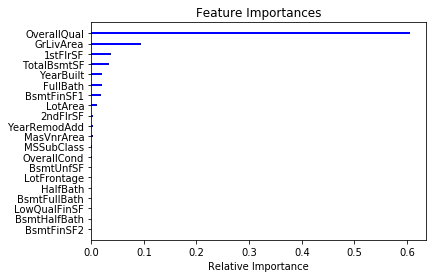

In [10]:
features = X_train.columns
importances = model_rf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], height=0.2, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Делаем Стеккинг

Возьмем модели LinearRegression,  KNeighborsRegressor , RandomForestRegressor

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

lr = LinearRegression()
kr = KNeighborsRegressor(5)
rf = RandomForestRegressor(n_estimators=10)

models = [lr, kr, rf]

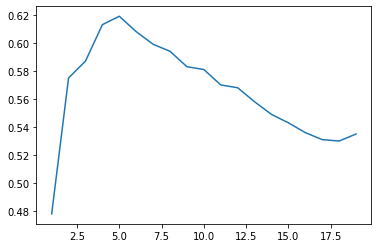

In [15]:
ks=range(1,20)
r2_val=[]
for n in ks:
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train,y_train.ravel())
    y_pred=model.predict(X_test)
    r2_val.append(r2_score(y_test, y_pred).round(3))
plt.plot(ks, r2_val)
plt.show()

In [13]:
# ГРАФИК какойто очень странный. Я гдето ошибся или все окей?

будем считать что оптимальное количество соседий для KNN - 5

In [16]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

Для линейной регресии нам нужно нормализовать данные и заполнить пропуски

In [17]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

In [18]:
from sklearn.model_selection import KFold
stack_cv = KFold(n_splits=10)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(models[0], X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')


print('KNN features...')
meta_tr, meta_te = get_meta_features(models[1], X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knn_pred')



print('RF features...')
meta_tr, meta_te = get_meta_features(models[2], X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')



LR features...
KNN features...
RF features...


In [19]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

Для стекинга мета признаков используем Linear Regression

In [20]:
model_lr_meta = LinearRegression(n_jobs=-1)
model_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [21]:
y_pred_meta_test = model_lr_meta.predict(X_meta_test)

print(f"MSE = {np.mean(-cross_val_score(model_lr_meta,X_meta_test,y_test,cv=10,scoring='neg_mean_squared_error'))}")

MSE = 1289600312.8615599


In [ ]:
по сравнению с раньше:

MSE = 2931894461.5237074

MSE Значительно улучшился по сравнениею просто с RandomForestRegressor

Коэффициенты объединяющей линейной модели

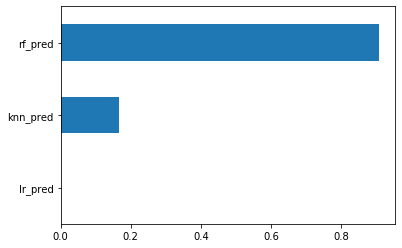

In [22]:

pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

In [23]:
# В этой работе я немного неуверен касательно метрик качества. Правильно ли я посчитал их?
